In [154]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib

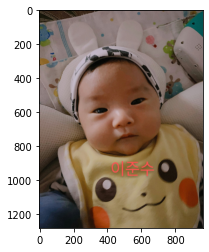

In [155]:
my_image_path = '/content/sample_data/junsoo1.jpg'
img_bgr = cv2.imread(my_image_path) # OpenCV로 이미지를 불러오기
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #RGB 이미지로
plt.imshow(img_rgb)
plt.show()

rectangles[[(233, 418) (788, 973)]]


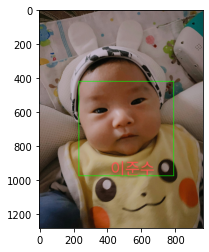

In [156]:
detector_hog = dlib.get_frontal_face_detector()  # hog detector 선언
dlib_rects = detector_hog(img_rgb, 1)  # (image, 이미지 피라미드 수)

# 찾은 얼굴 영역 박스 리스트, 여러 얼굴이 있을 수 있음.
print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

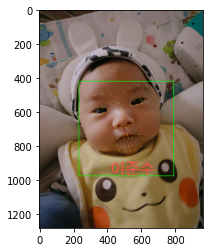

In [157]:
# landmark 모델 불러오기
model_path = '/content/sample_data/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark 찾아냄.
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해 둠.
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# landmark  영상 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [158]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30]) # 코의 index 30
    x = landmark[30][0] 
    y = landmark[30][1] 
    w = dlib_rect.width()  
    h = dlib_rect.width()  
    print('(x, y): (%d, %d)'%(x, y))  # 코의 좌표
    print('(w, h): (%d, %d)'%(w, h))  # 얼굴 크기

(494, 639)
(x, y): (494, 639)
(w, h): (556, 556)


(556, 556, 3)


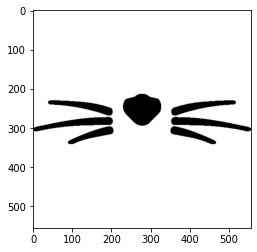

In [159]:
# 스티커 이미지 불러오기
sticker_path = '/content/sample_data/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))  # 스티커 크기를 얼굴 크기로 조정

sticker_copy = img_sticker.copy() # 스티커 변환을 위해 sticker_copy

print(img_sticker.shape)
plt.imshow(img_sticker )
plt.show()

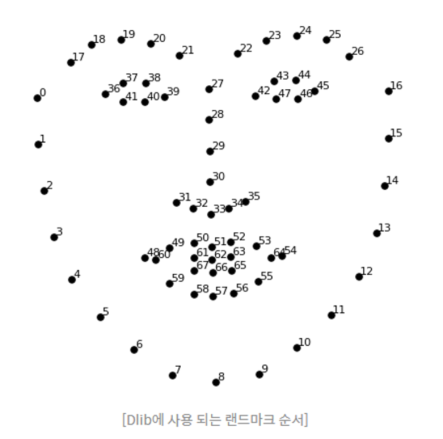

[어파인 변환과 투시 변환](https://deep-learning-study.tistory.com/200)

## 명예의 전당 서태원님 코드 차용.

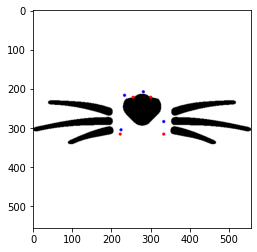

In [160]:
# source 좌표
src_points = [
    (int(w * 0.46), int(w * 0.4)),
    (int(w * 0.54), int(w * 0.4)),
    (int(w * 0.4), int(w * 0.57)),
    (int(w * 0.6), int(w * 0.57)),
]



# 랜드마크를 이용한 destination 좌표
# 28, 31, 35(코 위에 있는 좌표), 49, 53(입 위 좌표) 이용
dst_points = [
    (
        (landmark[31][0] + landmark[28][0]) // 2 - l,
        (landmark[31][1] + landmark[28][1]) // 2 - t,
    ),
    (
        (landmark[35][0] + landmark[28][0]) // 2 - l,
        (landmark[35][1] + landmark[28][1]) // 2 - t,
    ),
    (
        (landmark[31][0] + landmark[49][0]) // 2 - l,
        (landmark[31][1] + landmark[49][1]) // 2 - t,
    ),
    (
        (landmark[35][0] + landmark[53][0]) // 2 - l,
        (landmark[35][1] + landmark[53][1]) // 2 - t,
    ),
]

# Red: Source 좌표
for point in src_points:
    cv2.circle(sticker_copy, point, 4, (255, 0, 0), -1)

# Blue: Destination 좌표    
for point in dst_points:
    cv2.circle(sticker_copy, point, 4, (0, 0, 255), -1)

plt.imshow(sticker_copy)
plt.show()

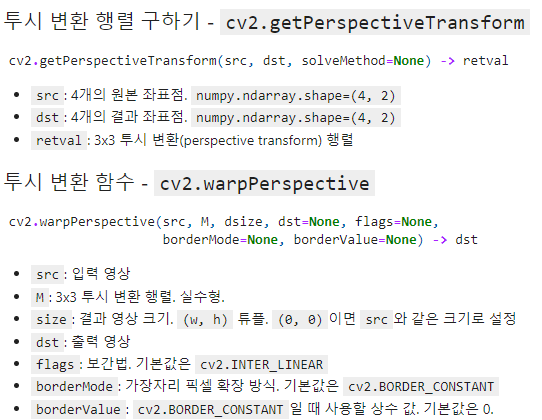

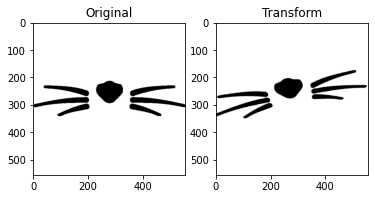

In [161]:
# 좌표를 실수영 nd.array로 바꿈
src = np.float32(src_points)
dst = np.float32(dst_points)

M = cv2.getPerspectiveTransform(src, dst)  # 투시 변환 행렬
transformed_sticker = cv2.warpPerspective(img_sticker, M, (w,h),
                         borderValue = [255, 255, 255, 255]) # 가장 자리 픽셀 확장은 흰색

plt.subplot(121),plt.imshow(img_sticker),plt.title('Original')
plt.subplot(122),plt.imshow(transformed_sticker,),plt.title('Transform')
plt.show()

In [162]:
refined_x = x - (src_points[0][0] + src_points[1][0]) // 2
refined_y = y - (src_points[0][1] + src_points[1][1]) // 2
print(f"이미지에서 스티커 좌표(top-left): ({refined_x}, {refined_y})")

이미지에서 스티커 좌표(top-left): (217, 417)


스티커 크기:  (556, 556, 3)


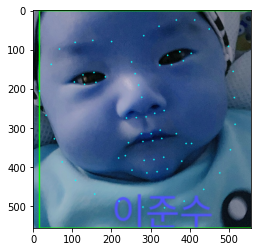

In [163]:
# 스티커 적용
sticker_area = img_show[refined_y : refined_y + img_sticker.shape[0],
                        refined_x : refined_x + img_sticker.shape[1]]


plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
print("스티커 크기: ", sticker_area.shape)
plt.imshow(sticker_area)

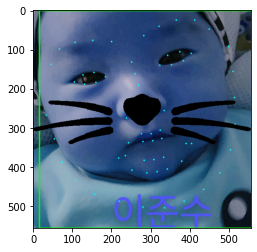

In [164]:
# 고양이 수염 좌표만 이동한 경우

# 사진에서 스티커가 붙여질 범위
sticker_area1 = img_show[refined_y : refined_y + img_sticker.shape[0], 
                         refined_x : refined_x + img_sticker.shape[1],]

# True->스티커, False->sticker_area
img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] = \
    np.where(img_sticker==0, img_sticker, sticker_area1).astype(np.uint8) 

plt.imshow(sticker_area1)

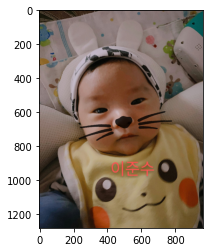

In [165]:
# 고양이 수염 변환 
# 변환시켜준 경우
sticker_area2 = img_bgr[t : t + transformed_sticker.shape[0], l : l + transformed_sticker.shape[1]]

# (l, t) : left-top 좌표
# 스티커가 검은색(transformed_sticker==0)이면 스티커를 넣고, 거짓이면 이미지를 넣어준다.
img_bgr[t : t + transformed_sticker.shape[0], l : l + transformed_sticker.shape[1]] = \
np.where(
    transformed_sticker == 0, cv2.addWeighted(transformed_sticker, 0.8, sticker_area2, 0.2, 0), sticker_area2
).astype(np.uint8)

plt.imshow(sticker_area2)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 후기

투시 변환 행렬 구하기, 투시 변환 함수 등 어려움<br>
여러명이 있는 사진 적용을 위해 클래스로 만든 코드 카피하여 사용해 보았음.